In [1]:
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# at the top of your notebook
'''segmentation_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std= [0.229, 0.224, 0.225])
])
'''

segmentation_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


'''segmentation_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])'''

classification_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [2]:
# Model Architectures
# Helper functions
from PIL import ImageDraw

class MelanomaClassifier(nn.Module):
    """
    Model architecture TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                          stride=2) # default stride value is same as kernel_size

        )

        hidden_units_B = hidden_units * 2 #increase out-feautures hidden units (32 to 64)
        print(hidden_units_B) # debug

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units_B, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units_B, hidden_units_B, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        hidden_units = hidden_units_B * 2 #increase out-feautures hidden units_B (64 to 128)
        print(hidden_units) # debug

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(hidden_units_B, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        hidden_units_B = hidden_units * 2 #ncrease out-feautures hidden units (128 to 256)
        print(hidden_units_B) # debug
        
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units_B, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units_B, hidden_units_B, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self._to_linear = None
        self._compute_linear_input_size(input_shape) #dynamically compute in_features

        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=self._to_linear,
                      out_features=output_shape)

        )

    # Function to automate the calculation of in_features for the final nn.linear layer by passing a dummy tensor into the model.
    def _compute_linear_input_size(self, input_shape):
        """Pass a dummy tensor through conv layers by making an inference to determine in_features size."""
        with torch.no_grad():
            dummy_input = torch.randn(1, input_shape, 224, 224)  # Dummy tensor input to simulate the changes of the in_features as a tensor passes the conv blocks.
            output = self.conv_block_1(dummy_input)
            output = self.conv_block_2(output)
            output = self.conv_block_3(output)
            output = self.conv_block_4(output)
            self._to_linear = output.view(1, -1).shape[1]  # Flatten and get feature size
            print("Computed in_features:", self._to_linear)  # Debugging

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        print(f"Feature map shape before flattening: {x.shape}")  # Debugging line
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

#create model instance
torch.manual_seed(42)
model_0 = MelanomaClassifier(input_shape=3, # number of color channels (3 for RGB)
                hidden_units=10, #initial hidden units
                output_shape=1).to(device)
model_0

def circular_crop(img, radius_ratio=0.4):
    w, h = img.size
    r = int(min(w, h) * radius_ratio)
    cx, cy = w // 2, h // 2

    mask = Image.new('L', (w, h), 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((cx - r, cy - r, cx + r, cy + r), fill=255)

    result = Image.new("RGB", (w, h))
    result.paste(img, mask=mask)
    return result  # ✅ Return the masked (circularly cropped) image



20
40
80
Computed in_features: 15680


In [3]:
#set up UNet model and melanoma classifier model
from model import UNet

# instantiate & load weights
seg_model = UNet(n_channels=3, n_classes=1, bilinear=False)
seg_model.load_state_dict(torch.load(
    'C:/Users/Fourth/models/unet_dice0.8369_save1746204838.pt',
    map_location=device
))
seg_model.to(device).eval()

#set up Melanoma Classifier model

MODEL_PATH = Path("saved models")
MODEL_FILE = MODEL_PATH / "model_with-UNET_epoch16+3+16-finetuned_acc0.5493_thres0.5_minpixel5000_batch8.pth"

checkpoint = torch.load(MODEL_FILE)
model_0.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms

def predict_melanoma(image_path, seg_model, clf_model, threshold=0.5, min_pixels=5000):
    original_image = Image.open(image_path).convert("RGB")

    # Step 1: Segment - Resize to 300x300
    seg_input = segmentation_transform(original_image).unsqueeze(0).to(device)

    with torch.no_grad():
        mask_pred = seg_model(seg_input)
        #mask_pred = torch.sigmoid(mask_pred)
        mask_pred = (mask_pred > threshold).float()

    mask_np = mask_pred.squeeze().cpu().numpy()

    pixel_count = (mask_np > 0).sum()

    if pixel_count < min_pixels:
        print(f"Applying circular crop (pixels={pixel_count})")
        processed_image = circular_crop(original_image)
        final_mask = None
    else:
        print(f"Applying segmentation mask crop (pixels={pixel_count})")
        # Resize mask to match original image
        mask_resized = Image.fromarray((mask_np * 255).astype("uint8")).resize(original_image.size)
        mask_np_resized = np.array(mask_resized) / 255.0

        image_np = np.array(original_image)
        mask_np_exp = np.expand_dims(mask_np_resized, axis=-1)
        segmented_np = (image_np * mask_np_exp).astype("uint8")
        processed_image = Image.fromarray(segmented_np)
        final_mask = mask_resized

    # Resize to 224x224 for classifier
    clf_input = classification_transform(processed_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = clf_model(clf_input)
        prob = torch.sigmoid(output).item()

    return prob, original_image, final_mask, processed_image


Applying segmentation mask crop (pixels=8210)
Feature map shape before flattening: torch.Size([1, 80, 14, 14])
Melanoma probability: 0.4996


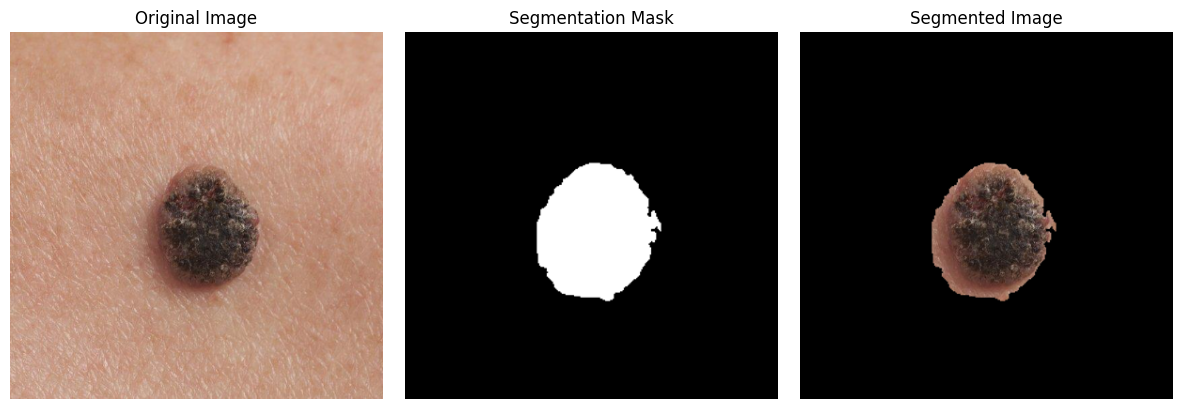

In [14]:
#image_path = "C:/Users/Fourth/data/melanoma_cancer_dataset/test/malignant/melanoma_10584.jpg"
image_path = "C:/Users/Fourth/test images/malignant3.jpg"
prob, orig_img, mask_img, proc_img = predict_melanoma(image_path, seg_model, model_0)

print(f"Melanoma probability: {prob:.4f}")

# Plot
fig, axs = plt.subplots(1, 3 if mask_img else 2, figsize=(12, 4))

axs[0].imshow(orig_img)
axs[0].set_title("Original Image")
axs[0].axis("off")

if mask_img:
    axs[1].imshow(mask_img, cmap="gray")
    axs[1].set_title("Segmentation Mask")
    axs[1].axis("off")

    axs[2].imshow(proc_img)
    axs[2].set_title("Segmented Image")
    axs[2].axis("off")
else:
    axs[1].imshow(proc_img)
    axs[1].set_title("Cropped Image")
    axs[1].axis("off")

plt.tight_layout()
plt.show()
